## split dataset

In [ ]:
import os
import shutil
from pathlib import Path
import numpy as np

def read_yolo_label(label_path):
    """Read YOLO label file and return class indices."""
    with open(label_path, 'r') as f:
        lines = f.readlines()
    class_indices = set()
    for line in lines:
        if line.strip():
            class_idx = int(line.split()[0])
            class_indices.add(class_idx)
    return class_indices

def separate_classes(base_dir, split_type):
    """Separate images and labels by class for a given split (train/val)."""
    images_dir = Path(base_dir) / split_type / 'images'
    labels_dir = Path(base_dir) / split_type / 'labels'
    
    # Create dictionary to store class information
    class_files = {}
    
    # Process each label file
    for label_file in labels_dir.glob('*.txt'):
        image_name = label_file.stem
        image_file = images_dir / f"{image_name}.jpg"  # Assuming jpg format, modify if needed
        
        # Skip if image doesn't exist
        if not image_file.exists():
            print(f"Warning: No matching image for {label_file}")
            continue
            
        # Get class indices from label file
        class_indices = read_yolo_label(label_file)
        
        # Add files to corresponding classes
        for class_idx in class_indices:
            if class_idx not in class_files:
                class_files[class_idx] = []
            class_files[class_idx].append((image_file, label_file))
    
    # Create directories and copy files
    for class_idx in class_files:
        # Create class directories
        class_dir = Path(base_dir) / split_type / f'class{class_idx}'
        class_images_dir = class_dir / 'images'
        class_labels_dir = class_dir / 'labels'
        
        os.makedirs(class_images_dir, exist_ok=True)
        os.makedirs(class_labels_dir, exist_ok=True)
        
        # Copy files
        for image_file, label_file in class_files[class_idx]:
            shutil.copy2(image_file, class_images_dir / image_file.name)
            shutil.copy2(label_file, class_labels_dir / label_file.name)
            
        print(f"{split_type}/class{class_idx}: {len(class_files[class_idx])} files")

def main():
    base_dir = 'dsds'  # Change this to your dataset path
    
    # Process both train and val splits
    for split_type in ['train', 'val']:
        print(f"\nProcessing {split_type} split:")
        separate_classes(base_dir, split_type)

if __name__ == "__main__":
    main()

## Data Count

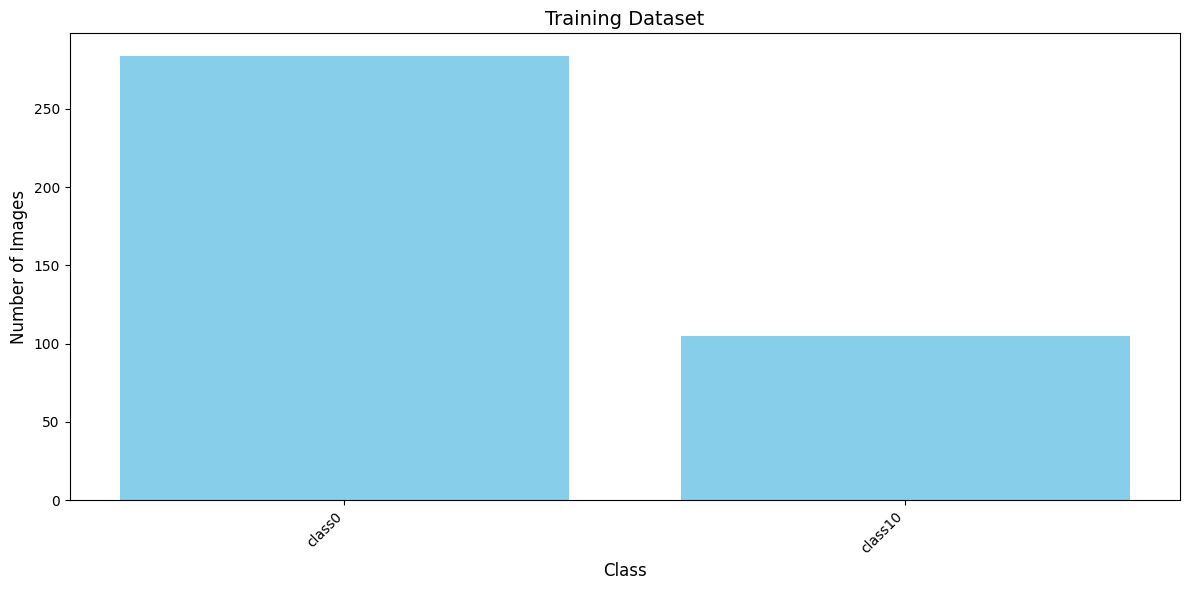

In [11]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dstest/train"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Training Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


## Generate Random Zoom Outs for Train 

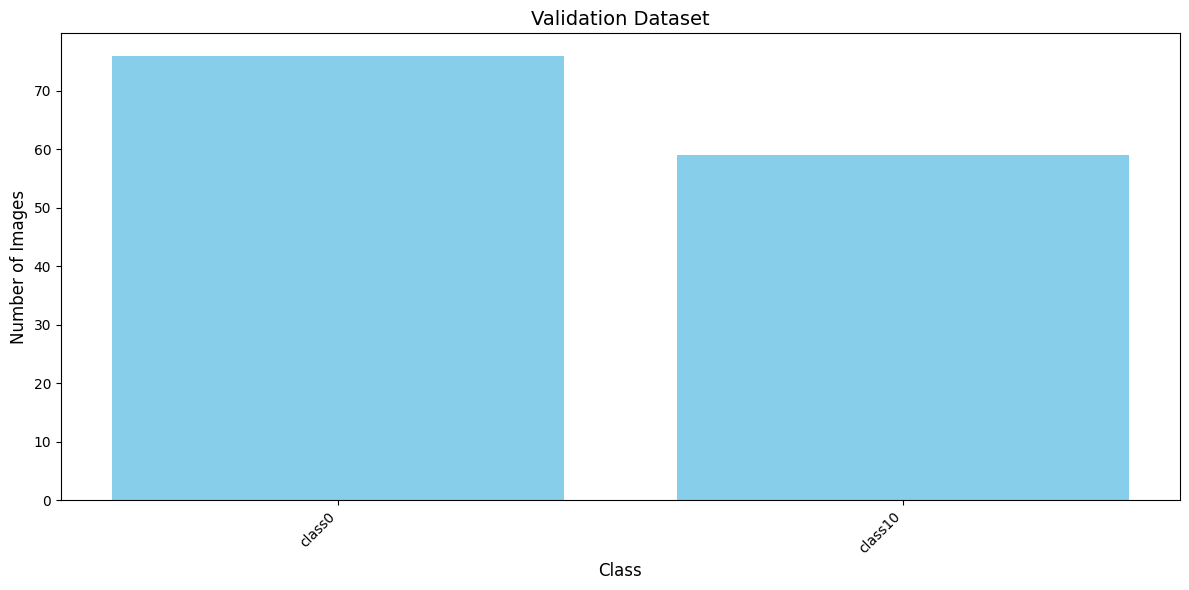

In [12]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dsTest/val"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Validation Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


In [4]:
import os
import random
from PIL import Image
from collections import defaultdict

def apply_zoom_out(image_path, label_path, zoom_out_factor, output_image_path, output_label_path):
    """
    Apply zoom out augmentation to an image and its labels by adding white borders
    
    Args:
    - image_path: Path to the input image
    - label_path: Path to the input label file
    - zoom_out_factor: Factor by which to zoom out (< 1)
    - output_image_path: Path to save the zoomed out image
    - output_label_path: Path to save the zoomed out labels
    """
    # Load the image
    original_image = Image.open(image_path)
    img_width, img_height = original_image.size

    # Calculate new image dimensions
    new_width = int(img_width / zoom_out_factor)
    new_height = int(img_height / zoom_out_factor)

    # Create a new white background image
    zoomed_out_image = Image.new('RGB', (new_width, new_height), color='white')

    # Calculate positioning to center the original image
    left = (new_width - img_width) // 2
    top = (new_height - img_height) // 2

    # Paste the original image onto the white background
    zoomed_out_image.paste(original_image, (left, top))

    # Adjust bounding box labels
    zoomed_labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convert normalized coordinates to pixel coordinates of original image
            px_x_center = x_center * img_width
            px_y_center = y_center * img_height
            px_width = width * img_width
            px_height = height * img_height

            # Adjust pixel coordinates to new white background image
            new_px_x_center = px_x_center + left
            new_px_y_center = px_y_center + top

            # Convert back to normalized coordinates of the new image
            new_x_center = new_px_x_center / new_width
            new_y_center = new_px_y_center / new_height
            new_width = px_width / new_width
            new_height = px_height / new_height

            # Strictly enforce valid normalized coordinates
            new_x_center = max(0, min(1, new_x_center))
            new_y_center = max(0, min(1, new_y_center))
            new_width = max(0, min(1, new_width))
            new_height = max(0, min(1, new_height))

            # Ensure the entire bounding box is within image bounds
            if (new_x_center - new_width/2 >= 0 and 
                new_x_center + new_width/2 <= 1 and 
                new_y_center - new_height/2 >= 0 and 
                new_y_center + new_height/2 <= 1):
                # Add the modified label
                zoomed_labels.append(f"{class_id} {new_x_center:.6f} {new_y_center:.6f} {new_width:.6f} {new_height:.6f}")

    # Only save if we have valid labels
    if zoomed_labels:
        # Resize the zoomed out image back to original size (optional, can be removed if you want variable size)
        zoomed_out_image = zoomed_out_image.resize((img_width, img_height), Image.LANCZOS)
        
        # Save the zoomed out image and labels
        zoomed_out_image.save(output_image_path)
        with open(output_label_path, 'w') as f:
            f.writelines('\n'.join(zoomed_labels) + '\n')
        return True
    return False

def balance_dataset(base_path, target_count=25):
    """Generate 175 zoom-out augmentations per class"""
    # Available zoom out factors with more fine-grained progression
    zoom_out_factors = [round(0.88 - x * 0.04, 2) for x in range(7)]  # [0.88, 0.84, 0.80, 0.76, 0.72, 0.68, 0.64]
    
    # Define the output directory for augmented data
    output_base_path = "dsout/train"
    os.makedirs(output_base_path, exist_ok=True)

    # Process each class directory
    class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d)) and d.startswith('class')]
    
    for class_dir in class_dirs:
        class_path = os.path.join(base_path, class_dir)
        images_dir = os.path.join(class_path, 'images')
        labels_dir = os.path.join(class_path, 'labels')
        
        # Ensure directories exist
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)
        
        # Get list of original images (without zoom annotations)
        original_images = [f for f in os.listdir(images_dir) 
                         if f.endswith(('.jpg', '.jpeg', '.png')) and '(z' not in f]
        
        print(f"\nProcessing {class_dir}:")
        print(f"Original images: {len(original_images)}")
        
        # Ensure at least 175 images are generated per class
        print(f"Generating {target_count} augmented images...")
        
        # Keep track of used zoom out factors for each image
        used_zoom_factors = defaultdict(set)
        
        augmentations_created = 0
        attempts = 0
        max_attempts = target_count * 20  # Increased attempts to account for potential rejections
        
        while augmentations_created < target_count and attempts < max_attempts:
            attempts += 1
            
            # Get a random original image
            image_file = random.choice(original_images)
            
            # Get available zoom out factors for this image
            available_factors = [f for f in zoom_out_factors 
                               if f not in used_zoom_factors[image_file]]
            
            if not available_factors:
                continue  # Skip if no available zoom out factors for this image
                
            # Choose random zoom out factor from available ones
            zoom_out_factor = random.choice(available_factors)
            used_zoom_factors[image_file].add(zoom_out_factor)
            
            # Setup paths for output in the new directory
            label_file = os.path.splitext(image_file)[0] + '.txt'
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, label_file)
            
            # Verify label file exists
            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_file}")
                continue
            
            # Create output filenames with zoom out factor
            base_name = os.path.splitext(image_file)[0]
            ext = os.path.splitext(image_file)[1]
            new_image_name = f"{base_name}(z{zoom_out_factor}){ext}"
            new_label_name = f"{base_name}(z{zoom_out_factor}).txt"
            
            output_image_path = os.path.join(output_base_path, class_dir, 'images', new_image_name)
            output_label_path = os.path.join(output_base_path, class_dir, 'labels', new_label_name)
            
            # Ensure the output directories exist
            os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
            os.makedirs(os.path.dirname(output_label_path), exist_ok=True)
            
            # Apply zoom out augmentation
            if apply_zoom_out(image_path, label_path, zoom_out_factor, output_image_path, output_label_path):
                augmentations_created += 1
                if augmentations_created % 10 == 0:
                    print(f"Generated {augmentations_created}/{target_count} augmented images")
            
        # Print statistics
        print(f"\nCompleted augmentation for {class_dir}")
        print(f"Total augmented images created: {augmentations_created}")
        print("\nZoom out factors used per image:")
        for img, factors in used_zoom_factors.items():
            if factors:
                print(f"  {img}: {sorted(factors)}")

if __name__ == "__main__":
    # Path to your dataset directory containing class0, class1, etc.
    dataset_path = "dstest/train"  # Adjust this to your dataset path
    
    print("Starting Generating balancing...")
    balance_dataset(dataset_path)
    print("\nDataset Generating completed!")


Starting dataset balancing...

Processing class0:
Original images: 284
Generating 25 augmented images...
Generated 10/25 augmented images
Generated 20/25 augmented images

Completed augmentation for class0
Total augmented images created: 25

Zoom out factors used per image:
  env_Balete-II-5-_jpg.rf.da02e12072428e8ef209556fa6c94b9b.jpg: [0.76]
  env_Balete-SS-8-_jpg.rf.68bb228f37ad3ee09dcc31b7f9e315a3.jpg: [0.64]
  white_bg_Balete-C-2-_jpg.rf.6f4ce6baaec0aa83629edda1bc27c61f.jpg: [0.84]
  white_bg_Balete-A-2-_jpg.rf.62f82d88f4d1686fe46d57286d4bbe99.jpg: [0.76]
  env_Balete-S-11-_jpg.rf.0b55c1c9c6caef204d195bba8939535e.jpg: [0.88]
  env_Balete-BB-5-_jpg.rf.f34c88c262845abf7713666d3436ee77.jpg: [0.88]
  env_Balete-B-8-_jpg.rf.c4cd48d9bff69066b349fc04d3721a01.jpg: [0.72]
  white_bg_Balete-B-35-_jpg.rf.936371a0433634b30b11148453498128.jpg: [0.72, 0.76]
  env_Balete-H-14-_jpg.rf.2fd4774a99646595ef7b0809188d70cc.jpg: [0.68]
  white_bg_Balete-C-60-_jpg.rf.c48d6eb28f09f1c8639aebf7c1474ec8.jpg:

## Generate Random Zoom Outs for Val

In [6]:
import os
import random
from PIL import Image
from collections import defaultdict

def apply_zoom_out(image_path, label_path, zoom_out_factor, output_image_path, output_label_path):
    """
    Apply zoom out augmentation to an image and its labels by adding white borders
    
    Args:
    - image_path: Path to the input image
    - label_path: Path to the input label file
    - zoom_out_factor: Factor by which to zoom out (< 1)
    - output_image_path: Path to save the zoomed out image
    - output_label_path: Path to save the zoomed out labels
    """
    # Load the image
    original_image = Image.open(image_path)
    img_width, img_height = original_image.size

    # Calculate new image dimensions
    new_width = int(img_width / zoom_out_factor)
    new_height = int(img_height / zoom_out_factor)

    # Create a new white background image
    zoomed_out_image = Image.new('RGB', (new_width, new_height), color='white')

    # Calculate positioning to center the original image
    left = (new_width - img_width) // 2
    top = (new_height - img_height) // 2

    # Paste the original image onto the white background
    zoomed_out_image.paste(original_image, (left, top))

    # Adjust bounding box labels
    zoomed_labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convert normalized coordinates to pixel coordinates of original image
            px_x_center = x_center * img_width
            px_y_center = y_center * img_height
            px_width = width * img_width
            px_height = height * img_height

            # Adjust pixel coordinates to new white background image
            new_px_x_center = px_x_center + left
            new_px_y_center = px_y_center + top

            # Convert back to normalized coordinates of the new image
            new_x_center = new_px_x_center / new_width
            new_y_center = new_px_y_center / new_height
            new_width = px_width / new_width
            new_height = px_height / new_height

            # Strictly enforce valid normalized coordinates
            new_x_center = max(0, min(1, new_x_center))
            new_y_center = max(0, min(1, new_y_center))
            new_width = max(0, min(1, new_width))
            new_height = max(0, min(1, new_height))

            # Ensure the entire bounding box is within image bounds
            if (new_x_center - new_width/2 >= 0 and 
                new_x_center + new_width/2 <= 1 and 
                new_y_center - new_height/2 >= 0 and 
                new_y_center + new_height/2 <= 1):
                # Add the modified label
                zoomed_labels.append(f"{class_id} {new_x_center:.6f} {new_y_center:.6f} {new_width:.6f} {new_height:.6f}")

    # Only save if we have valid labels
    if zoomed_labels:
        # Resize the zoomed out image back to original size (optional, can be removed if you want variable size)
        zoomed_out_image = zoomed_out_image.resize((img_width, img_height), Image.LANCZOS)
        
        # Save the zoomed out image and labels
        zoomed_out_image.save(output_image_path)
        with open(output_label_path, 'w') as f:
            f.writelines('\n'.join(zoomed_labels) + '\n')
        return True
    return False

def balance_dataset(base_path, target_count=10):
    """Generate 175 zoom-out augmentations per class"""
    # Available zoom out factors with more fine-grained progression
    zoom_out_factors = [round(0.88 - x * 0.04, 2) for x in range(7)]  # [0.88, 0.84, 0.80, 0.76, 0.72, 0.68, 0.64]
    
    # Define the output directory for augmented data
    output_base_path = "dsout/val"
    os.makedirs(output_base_path, exist_ok=True)

    # Process each class directory
    class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d)) and d.startswith('class')]
    
    for class_dir in class_dirs:
        class_path = os.path.join(base_path, class_dir)
        images_dir = os.path.join(class_path, 'images')
        labels_dir = os.path.join(class_path, 'labels')
        
        # Ensure directories exist
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)
        
        # Get list of original images (without zoom annotations)
        original_images = [f for f in os.listdir(images_dir) 
                         if f.endswith(('.jpg', '.jpeg', '.png')) and '(z' not in f]
        
        print(f"\nProcessing {class_dir}:")
        print(f"Original images: {len(original_images)}")
        
        # Ensure at least 175 images are generated per class
        print(f"Generating {target_count} augmented images...")
        
        # Keep track of used zoom out factors for each image
        used_zoom_factors = defaultdict(set)
        
        augmentations_created = 0
        attempts = 0
        max_attempts = target_count * 20  # Increased attempts to account for potential rejections
        
        while augmentations_created < target_count and attempts < max_attempts:
            attempts += 1
            
            # Get a random original image
            image_file = random.choice(original_images)
            
            # Get available zoom out factors for this image
            available_factors = [f for f in zoom_out_factors 
                               if f not in used_zoom_factors[image_file]]
            
            if not available_factors:
                continue  # Skip if no available zoom out factors for this image
                
            # Choose random zoom out factor from available ones
            zoom_out_factor = random.choice(available_factors)
            used_zoom_factors[image_file].add(zoom_out_factor)
            
            # Setup paths for output in the new directory
            label_file = os.path.splitext(image_file)[0] + '.txt'
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, label_file)
            
            # Verify label file exists
            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_file}")
                continue
            
            # Create output filenames with zoom out factor
            base_name = os.path.splitext(image_file)[0]
            ext = os.path.splitext(image_file)[1]
            new_image_name = f"{base_name}(z{zoom_out_factor}){ext}"
            new_label_name = f"{base_name}(z{zoom_out_factor}).txt"
            
            output_image_path = os.path.join(output_base_path, class_dir, 'images', new_image_name)
            output_label_path = os.path.join(output_base_path, class_dir, 'labels', new_label_name)
            
            # Ensure the output directories exist
            os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
            os.makedirs(os.path.dirname(output_label_path), exist_ok=True)
            
            # Apply zoom out augmentation
            if apply_zoom_out(image_path, label_path, zoom_out_factor, output_image_path, output_label_path):
                augmentations_created += 1
                if augmentations_created % 10 == 0:
                    print(f"Generated {augmentations_created}/{target_count} augmented images")
            
        # Print statistics
        print(f"\nCompleted augmentation for {class_dir}")
        print(f"Total augmented images created: {augmentations_created}")
        print("\nZoom out factors used per image:")
        for img, factors in used_zoom_factors.items():
            if factors:
                print(f"  {img}: {sorted(factors)}")

if __name__ == "__main__":
    # Path to your dataset directory containing class0, class1, etc.
    dataset_path = "dstest/val"  # Adjust this to your dataset path
    
    print("Starting Generating balancing...")
    balance_dataset(dataset_path)
    print("\nDataset Generating completed!")


Starting Generating balancing...

Processing class0:
Original images: 76
Generating 10 augmented images...
Generated 10/10 augmented images

Completed augmentation for class0
Total augmented images created: 10

Zoom out factors used per image:
  white_bg_Balete-B-3-_jpg.rf.537c671b442f73341bfbfb1ff71cf5de.jpg: [0.84]
  white_bg_Balete-B-36-_jpg.rf.311002fc82a07a0e10e9d7664faad644.jpg: [0.76]
  env_Balete-DD-17-_jpg.rf.275d730a05ff357c5ba80ff81aba346f.jpg: [0.8]
  white_bg_Balete-B-57-_jpg.rf.43e6c4b6a7a82dc3ff017c7c250a2296.jpg: [0.88]
  env_Balete-O-42-_JPG.rf.abfe41a8c91ed9aa32f3c36ac1c16877.jpg: [0.88]
  env_Balete-CC-4-_jpg.rf.acad106c6487508e0e5aa28c0c5d6d4f.jpg: [0.68]
  env_Balete-GG-2-_jpg.rf.e742b4c99f660914d785f3bd460fe13a.jpg: [0.68]
  white_bg_Balete-C-6-_jpg.rf.e96e7282d34b4413e126ea8906a5872c.jpg: [0.84]
  env_Balete-E-59-_jpg.rf.fe020036a4c7092b042d16ebe055b4f1.jpg: [0.88]
  env_Balete-O-6-_JPG.rf.a5bdd603a42aafb468a93e44e7e6ea25.jpg: [0.76]

Processing class10:
Original

## Generated zoom out count for Train and Val 

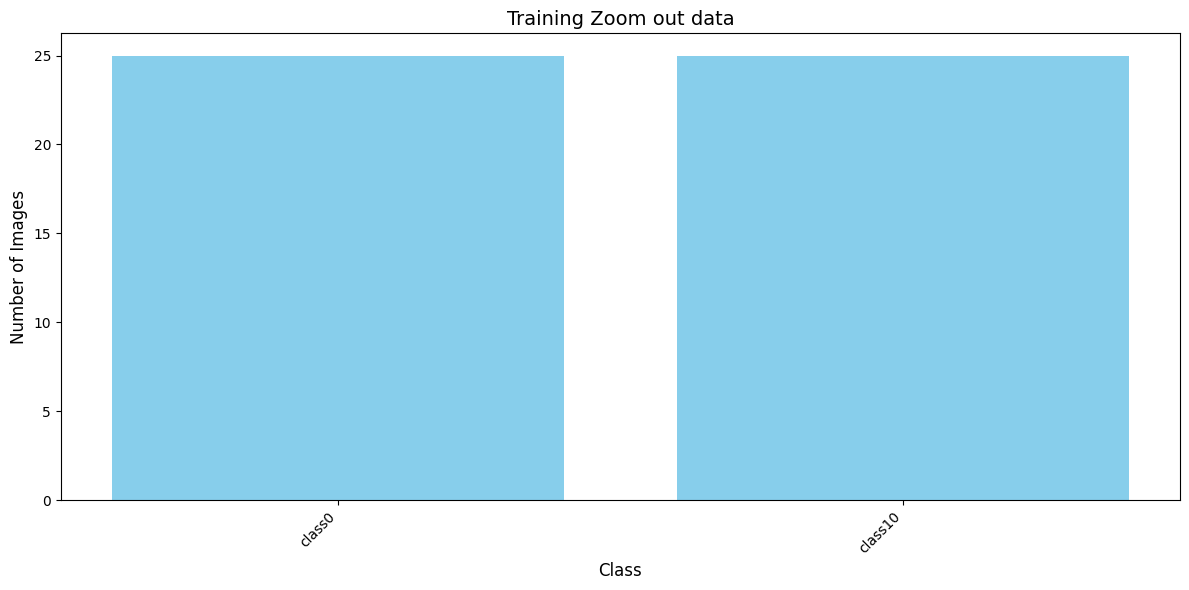

In [8]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dsout/train"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Training Zoom out data", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


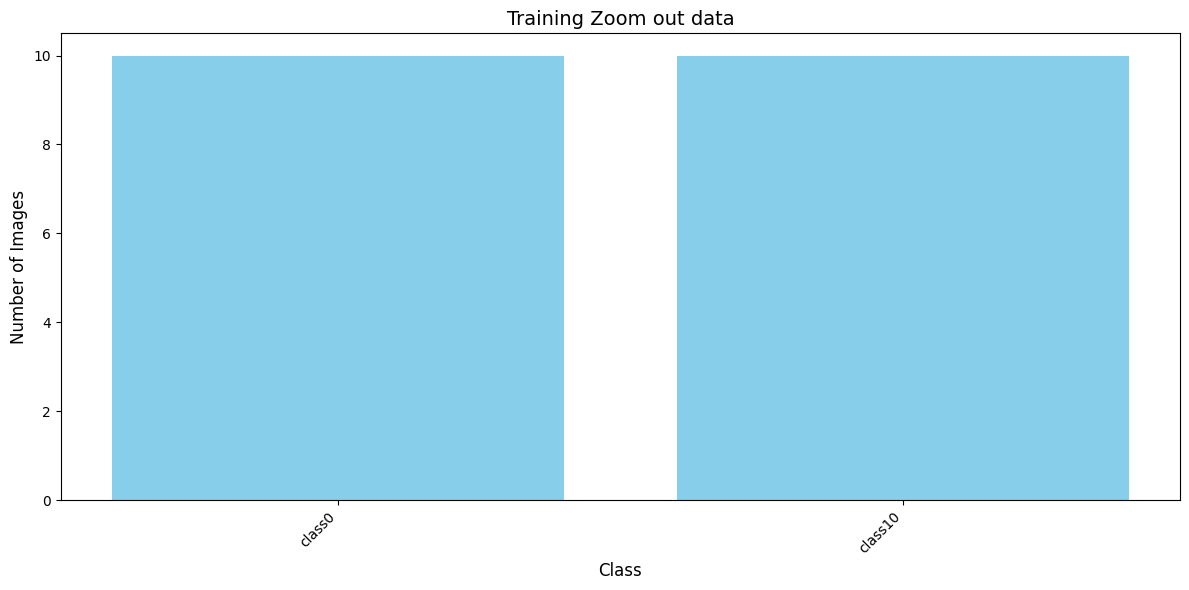

In [9]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dsout/val"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Validation Zoom out data", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


## Generate Random Zoom for training set

In [13]:
import os
import random
from PIL import Image
from collections import defaultdict

def apply_zoom(image_path, label_path, zoom_factor, output_image_path, output_label_path):
    """
    Apply zoom augmentation to an image and its labels with improved bounding box adjustment
    
    Args:
    - image_path: Path to the input image
    - label_path: Path to the input label file
    - zoom_factor: Factor by which to zoom (> 1)
    - output_image_path: Path to save the zoomed image
    - output_label_path: Path to save the zoomed labels
    """
    # Load the image
    image = Image.open(image_path)
    img_width, img_height = image.size

    # Calculate crop dimensions for zoom
    crop_width = img_width / zoom_factor
    crop_height = img_height / zoom_factor
    left = (img_width - crop_width) / 2
    top = (img_height - crop_height) / 2
    right = left + crop_width
    bottom = top + crop_height

    # Crop and resize the image back to original dimensions
    cropped_image = image.crop((left, top, right, bottom))
    zoomed_image = cropped_image.resize((img_width, img_height), Image.LANCZOS)

    # Adjust bounding box labels
    zoomed_labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convert normalized coordinates to pixel coordinates
            px_x_center = x_center * img_width
            px_y_center = y_center * img_height
            px_width = width * img_width
            px_height = height * img_height

            # Adjust pixel coordinates based on crop
            px_x_center = (px_x_center - left) * zoom_factor
            px_y_center = (px_y_center - top) * zoom_factor

            # Adjust pixel width and height
            px_width *= zoom_factor
            px_height *= zoom_factor

            # Convert back to normalized coordinates
            new_x_center = px_x_center / img_width
            new_y_center = px_y_center / img_height
            new_width = px_width / img_width
            new_height = px_height / img_height

            # Strictly enforce valid normalized coordinates
            new_x_center = max(0, min(1, new_x_center))
            new_y_center = max(0, min(1, new_y_center))
            new_width = max(0, min(1, new_width))
            new_height = max(0, min(1, new_height))

            # Ensure the entire bounding box is within image bounds
            if (new_x_center - new_width/2 >= 0 and 
                new_x_center + new_width/2 <= 1 and 
                new_y_center - new_height/2 >= 0 and 
                new_y_center + new_height/2 <= 1):
                # Add the modified label
                zoomed_labels.append(f"{class_id} {new_x_center:.6f} {new_y_center:.6f} {new_width:.6f} {new_height:.6f}")

    # Only save if we have valid labels
    if zoomed_labels:
        # Save the zoomed image and labels
        zoomed_image.save(output_image_path)
        with open(output_label_path, 'w') as f:
            f.writelines('\n'.join(zoomed_labels) + '\n')
        return True
    return False

def balance_dataset(base_path, target_count=350):
    """Balance all classes to have target_count images using zoom augmentation"""
    # Available zoom factors with more fine-grained progression
    zoom_factors = [round(x * 0.02 + 1.04, 2) for x in range(7)]  # [1.04, 1.06, 1.08, 1.10, 1.12, 1.14, 1.16]
    
    # Process each class directory
    class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d)) and d.startswith('class')]
    
    for class_dir in class_dirs:
        class_path = os.path.join(base_path, class_dir)
        images_dir = os.path.join(class_path, 'images')
        labels_dir = os.path.join(class_path, 'labels')
        
        # Ensure directories exist
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)
        
        # Get list of original images (without zoom annotations)
        original_images = [f for f in os.listdir(images_dir) 
                         if f.endswith(('.jpg', '.jpeg', '.png')) and '(z' not in f]
        
        print(f"\nProcessing {class_dir}:")
        print(f"Original images: {len(original_images)}")
        
        current_count = len([f for f in os.listdir(images_dir) 
                           if f.endswith(('.jpg', '.jpeg', '.png'))])
        num_needed = max(0, target_count - current_count)
        
        print(f"Current total images: {current_count}")
        print(f"Additional images needed: {num_needed}")
        
        if num_needed == 0:
            print("No augmentation needed for this class")
            continue

        # Keep track of used zoom factors for each image
        used_zoom_factors = defaultdict(set)
        
        # Calculate maximum augmentations possible
        max_possible = len(original_images) * len(zoom_factors)
        if max_possible < num_needed:
            print(f"Warning: Can only generate {max_possible} unique augmentations "
                  f"({len(original_images)} images × {len(zoom_factors)} zoom factors)")
            num_needed = max_possible
        
        augmentations_created = 0
        attempts = 0
        max_attempts = num_needed * 20  # Increased attempts to account for potential rejections
        
        while augmentations_created < num_needed and attempts < max_attempts:
            attempts += 1
            
            # Get a random original image
            image_file = random.choice(original_images)
            
            # Get available zoom factors for this image
            available_factors = [f for f in zoom_factors 
                               if f not in used_zoom_factors[image_file]]
            
            if not available_factors:
                continue  # Skip if no available zoom factors for this image
                
            # Choose random zoom factor from available ones
            zoom_factor = random.choice(available_factors)
            used_zoom_factors[image_file].add(zoom_factor)
            
            # Setup paths
            label_file = os.path.splitext(image_file)[0] + '.txt'
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, label_file)
            
            # Verify label file exists
            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_file}")
                continue
            
            # Create output filenames with zoom factor
            base_name = os.path.splitext(image_file)[0]
            ext = os.path.splitext(image_file)[1]
            new_image_name = f"{base_name}(z{zoom_factor}){ext}"
            new_label_name = f"{base_name}(z{zoom_factor}).txt"
            
            output_image_path = os.path.join(images_dir, new_image_name)
            output_label_path = os.path.join(labels_dir, new_label_name)
            
            # Apply zoom augmentation
            if apply_zoom(image_path, label_path, zoom_factor, output_image_path, output_label_path):
                augmentations_created += 1
                if augmentations_created % 10 == 0:
                    print(f"Generated {augmentations_created}/{num_needed} augmented images")
            
        # Print statistics
        print(f"\nCompleted augmentation for {class_dir}")
        print(f"Total augmented images created: {augmentations_created}")
        print("\nZoom factors used per image:")
        for img, factors in used_zoom_factors.items():
            if factors:
                print(f"  {img}: {sorted(factors)}")

if __name__ == "__main__":
    # Path to your dataset directory containing class0, class1, etc.
    dataset_path = "dstest/train"  # Adjust this to your dataset path
    
    print("Starting dataset balancing...")
    balance_dataset(dataset_path)
    print("\nDataset balancing completed!")

Starting dataset balancing...

Processing class0:
Original images: 284
Current total images: 284
Additional images needed: 66
Generated 10/66 augmented images
Generated 20/66 augmented images
Generated 30/66 augmented images
Generated 40/66 augmented images
Generated 50/66 augmented images
Generated 60/66 augmented images

Completed augmentation for class0
Total augmented images created: 66

Zoom factors used per image:
  env_Balete-M-19-_jpg.rf.7b3f7fb608624ea0b8a5d6549bf2efba.jpg: [1.1]
  env_Balete-I-21-_jpg.rf.6436d00d371e38c449f30c368b9d07fe.jpg: [1.06]
  white_bg_Balete-B-31-_jpg.rf.4ceb485deb37597c8821a5a8b7c5a320.jpg: [1.16]
  white_bg_Balete-B-33-_jpg.rf.00cf8826410683566b26b666b081e11b.jpg: [1.12]
  env_Balete-P-21-_jpg.rf.bf444fca55e0d101940a557588996aea.jpg: [1.1, 1.16]
  env_Balete-T-2-_JPG.rf.a439ef38e3ab9d0e67196ea3e7a25c8c.jpg: [1.1]
  white_bg_Balete-B-20-_jpg.rf.34ecf74a1cd6baf94dd0f73fc10eec1b.jpg: [1.06]
  env_Balete-DD-1-_jpg.rf.5fa2d6e642b3e37bbe7d6ced1da0e072.jpg

## New Data Count for Train

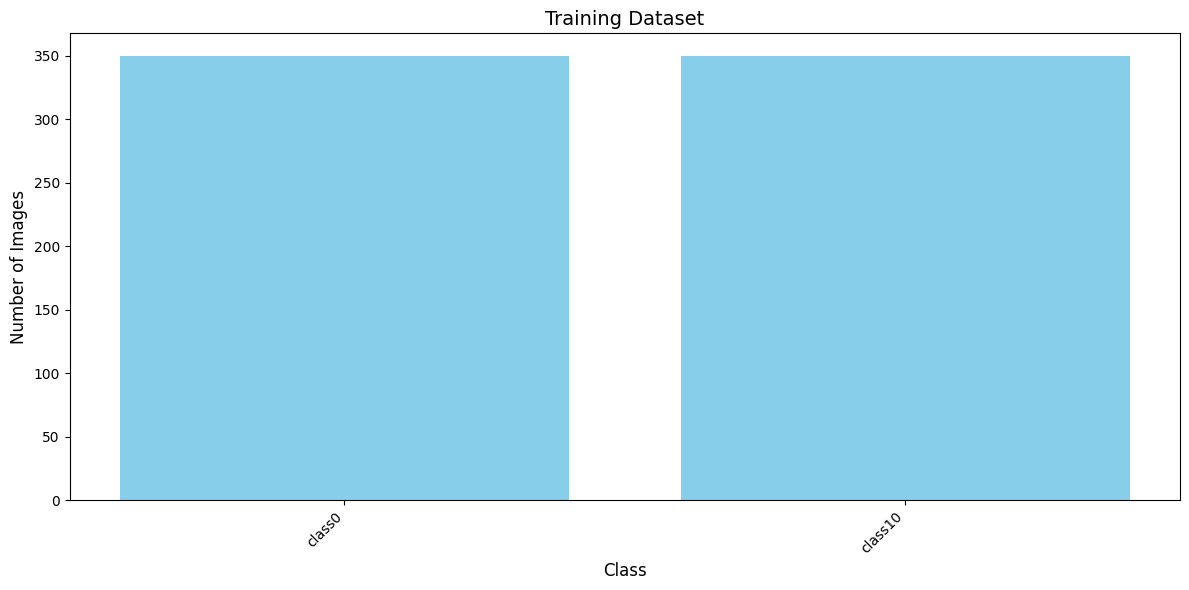

In [14]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dstest/train"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Training Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


## Generate Random Zoom for validation set

In [15]:
import os
import random
from PIL import Image
from collections import defaultdict

def apply_zoom(image_path, label_path, zoom_factor, output_image_path, output_label_path):
    """
    Apply zoom augmentation to an image and its labels with improved bounding box adjustment
    
    Args:
    - image_path: Path to the input image
    - label_path: Path to the input label file
    - zoom_factor: Factor by which to zoom (> 1)
    - output_image_path: Path to save the zoomed image
    - output_label_path: Path to save the zoomed labels
    """
    # Load the image
    image = Image.open(image_path)
    img_width, img_height = image.size

    # Calculate crop dimensions for zoom
    crop_width = img_width / zoom_factor
    crop_height = img_height / zoom_factor
    left = (img_width - crop_width) / 2
    top = (img_height - crop_height) / 2
    right = left + crop_width
    bottom = top + crop_height

    # Crop and resize the image back to original dimensions
    cropped_image = image.crop((left, top, right, bottom))
    zoomed_image = cropped_image.resize((img_width, img_height), Image.LANCZOS)

    # Adjust bounding box labels
    zoomed_labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convert normalized coordinates to pixel coordinates
            px_x_center = x_center * img_width
            px_y_center = y_center * img_height
            px_width = width * img_width
            px_height = height * img_height

            # Adjust pixel coordinates based on crop
            px_x_center = (px_x_center - left) * zoom_factor
            px_y_center = (px_y_center - top) * zoom_factor

            # Adjust pixel width and height
            px_width *= zoom_factor
            px_height *= zoom_factor

            # Convert back to normalized coordinates
            new_x_center = px_x_center / img_width
            new_y_center = px_y_center / img_height
            new_width = px_width / img_width
            new_height = px_height / img_height

            # Strictly enforce valid normalized coordinates
            new_x_center = max(0, min(1, new_x_center))
            new_y_center = max(0, min(1, new_y_center))
            new_width = max(0, min(1, new_width))
            new_height = max(0, min(1, new_height))

            # Ensure the entire bounding box is within image bounds
            if (new_x_center - new_width/2 >= 0 and 
                new_x_center + new_width/2 <= 1 and 
                new_y_center - new_height/2 >= 0 and 
                new_y_center + new_height/2 <= 1):
                # Add the modified label
                zoomed_labels.append(f"{class_id} {new_x_center:.6f} {new_y_center:.6f} {new_width:.6f} {new_height:.6f}")

    # Only save if we have valid labels
    if zoomed_labels:
        # Save the zoomed image and labels
        zoomed_image.save(output_image_path)
        with open(output_label_path, 'w') as f:
            f.writelines('\n'.join(zoomed_labels) + '\n')
        return True
    return False

def balance_dataset(base_path, target_count=100):
    """Balance all classes to have target_count images using zoom augmentation"""
    # Available zoom factors with more fine-grained progression
    zoom_factors = [round(x * 0.02 + 1.04, 2) for x in range(7)]  # [1.04, 1.06, 1.08, 1.10, 1.12, 1.14, 1.16]
    
    # Process each class directory
    class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d)) and d.startswith('class')]
    
    for class_dir in class_dirs:
        class_path = os.path.join(base_path, class_dir)
        images_dir = os.path.join(class_path, 'images')
        labels_dir = os.path.join(class_path, 'labels')
        
        # Ensure directories exist
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)
        
        # Get list of original images (without zoom annotations)
        original_images = [f for f in os.listdir(images_dir) 
                         if f.endswith(('.jpg', '.jpeg', '.png')) and '(z' not in f]
        
        print(f"\nProcessing {class_dir}:")
        print(f"Original images: {len(original_images)}")
        
        current_count = len([f for f in os.listdir(images_dir) 
                           if f.endswith(('.jpg', '.jpeg', '.png'))])
        num_needed = max(0, target_count - current_count)
        
        print(f"Current total images: {current_count}")
        print(f"Additional images needed: {num_needed}")
        
        if num_needed == 0:
            print("No augmentation needed for this class")
            continue

        # Keep track of used zoom factors for each image
        used_zoom_factors = defaultdict(set)
        
        # Calculate maximum augmentations possible
        max_possible = len(original_images) * len(zoom_factors)
        if max_possible < num_needed:
            print(f"Warning: Can only generate {max_possible} unique augmentations "
                  f"({len(original_images)} images × {len(zoom_factors)} zoom factors)")
            num_needed = max_possible
        
        augmentations_created = 0
        attempts = 0
        max_attempts = num_needed * 20  # Increased attempts to account for potential rejections
        
        while augmentations_created < num_needed and attempts < max_attempts:
            attempts += 1
            
            # Get a random original image
            image_file = random.choice(original_images)
            
            # Get available zoom factors for this image
            available_factors = [f for f in zoom_factors 
                               if f not in used_zoom_factors[image_file]]
            
            if not available_factors:
                continue  # Skip if no available zoom factors for this image
                
            # Choose random zoom factor from available ones
            zoom_factor = random.choice(available_factors)
            used_zoom_factors[image_file].add(zoom_factor)
            
            # Setup paths
            label_file = os.path.splitext(image_file)[0] + '.txt'
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, label_file)
            
            # Verify label file exists
            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_file}")
                continue
            
            # Create output filenames with zoom factor
            base_name = os.path.splitext(image_file)[0]
            ext = os.path.splitext(image_file)[1]
            new_image_name = f"{base_name}(z{zoom_factor}){ext}"
            new_label_name = f"{base_name}(z{zoom_factor}).txt"
            
            output_image_path = os.path.join(images_dir, new_image_name)
            output_label_path = os.path.join(labels_dir, new_label_name)
            
            # Apply zoom augmentation
            if apply_zoom(image_path, label_path, zoom_factor, output_image_path, output_label_path):
                augmentations_created += 1
                if augmentations_created % 10 == 0:
                    print(f"Generated {augmentations_created}/{num_needed} augmented images")
            
        # Print statistics
        print(f"\nCompleted augmentation for {class_dir}")
        print(f"Total augmented images created: {augmentations_created}")
        print("\nZoom factors used per image:")
        for img, factors in used_zoom_factors.items():
            if factors:
                print(f"  {img}: {sorted(factors)}")

if __name__ == "__main__":
    # Path to your dataset directory containing class0, class1, etc.
    dataset_path = "dstest/val"  # Adjust this to your dataset path
    
    print("Starting dataset balancing...")
    balance_dataset(dataset_path)
    print("\nDataset balancing completed!")

Starting dataset balancing...

Processing class0:
Original images: 76
Current total images: 76
Additional images needed: 24
Generated 10/24 augmented images
Generated 20/24 augmented images

Completed augmentation for class0
Total augmented images created: 24

Zoom factors used per image:
  env_Balete-F-20-_jpg.rf.17c61f1b18785f6e0a2a4df4e559e1c6.jpg: [1.04]
  white_bg_Balete-B-67-_jpg.rf.b8355685319ec03ac7423439b260c629.jpg: [1.04]
  env_Balete-E-57-_jpg.rf.54ba40d3cde0997f1f5266585346f228.jpg: [1.12]
  white_bg_Balete-Z-36-_JPG.rf.c6c1b1a5932f960232d672ae0bea6396.jpg: [1.1, 1.16]
  env_Balete-F-8-_jpg.rf.b699bcf8bd79bfe8b60302b4d9a09215.jpg: [1.08]
  env_Balete-Q-2-_jpg.rf.7a74675bdec7b4a5722cc54317ac8bfb.jpg: [1.06]
  white_bg_Balete-C-6-_jpg.rf.e96e7282d34b4413e126ea8906a5872c.jpg: [1.1, 1.12]
  white_bg_Balete-B-63-_jpg.rf.b827684146e5f0cc4dea5a85619ef65c.jpg: [1.04]
  white_bg_Balete-Z-33-_JPG.rf.656131b594df797c50c7206e1b5c8e09.jpg: [1.04]
  white_bg_Balete-B-38-_jpg.rf.674797cd

## New Data Count for Val

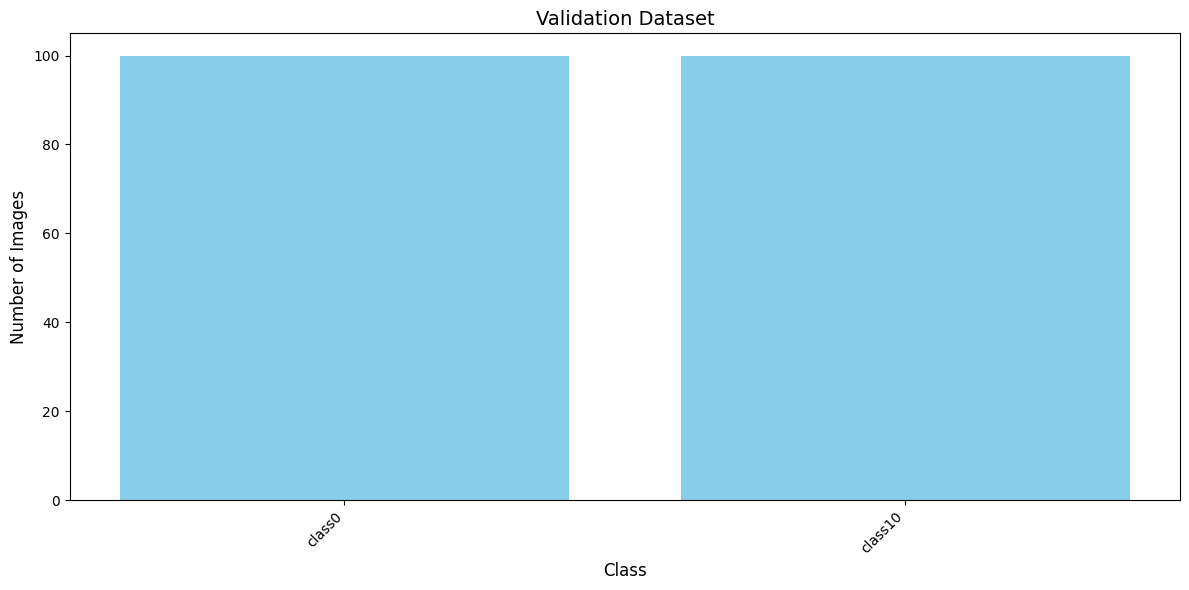

In [19]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dstest/val"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Validation Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


## Extra Data Clean-up

In [17]:
import os
import random

def cleanup_excess_images(base_path='dstest/val', target_count=100):
    """
    Randomly delete images and labels for classes that exceed the target count.
    
    Args:
    - base_path: Path to the dataset directory containing the validation dataset (default is 'dsds/val').
    - target_count: Maximum number of images allowed per class.
    """
    # Iterate through each class directory
    class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    for class_dir in class_dirs:
        class_path = os.path.join(base_path, class_dir)
        images_dir = os.path.join(class_path, 'images')
        labels_dir = os.path.join(class_path, 'labels')
        
        if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
            print(f"Skipping {class_dir}: 'images' or 'labels' directory not found.")
            continue
        
        # Get list of all images
        all_images = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]
        current_count = len(all_images)
        
        print(f"\nProcessing {class_dir}:")
        print(f"Current image count: {current_count}")
        
        if current_count > target_count:
            num_to_delete = current_count - target_count
            print(f"Need to delete {num_to_delete} images.")
            
            # Prefer deleting augmented images first (identified by patterns like '(z' in filename)
            augmented_images = [img for img in all_images if '(z' in img]
            deletion_candidates = augmented_images if augmented_images else all_images
            
            # Randomly select images to delete
            images_to_delete = random.sample(deletion_candidates, num_to_delete)
            
            # Delete selected images and their corresponding labels
            for image_to_delete in images_to_delete:
                # Remove image
                image_path = os.path.join(images_dir, image_to_delete)
                os.remove(image_path)
                
                # Remove corresponding label
                label_name = os.path.splitext(image_to_delete)[0] + '.txt'
                label_path = os.path.join(labels_dir, label_name)
                if os.path.exists(label_path):
                    os.remove(label_path)
            
            # Verify final count
            remaining_images = len([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))])
            print(f"Images after cleanup: {remaining_images}")
        else:
            print(f"No deletion required for {class_dir}.")

# Call the function
cleanup_excess_images(base_path='dsds/val', target_count=100)



Processing class0:
Current image count: 100
No deletion required for class0.

Processing class1:
Current image count: 100
No deletion required for class1.

Processing class10:
Current image count: 100
No deletion required for class10.

Processing class11:
Current image count: 100
No deletion required for class11.

Processing class12:
Current image count: 100
No deletion required for class12.

Processing class13:
Current image count: 100
No deletion required for class13.

Processing class14:
Current image count: 100
No deletion required for class14.

Processing class15:
Current image count: 100
No deletion required for class15.

Processing class16:
Current image count: 100
No deletion required for class16.

Processing class17:
Current image count: 100
No deletion required for class17.

Processing class18:
Current image count: 100
No deletion required for class18.

Processing class19:
Current image count: 100
No deletion required for class19.

Processing class2:
Current image count: 100

## Val Data Count After Cleanup

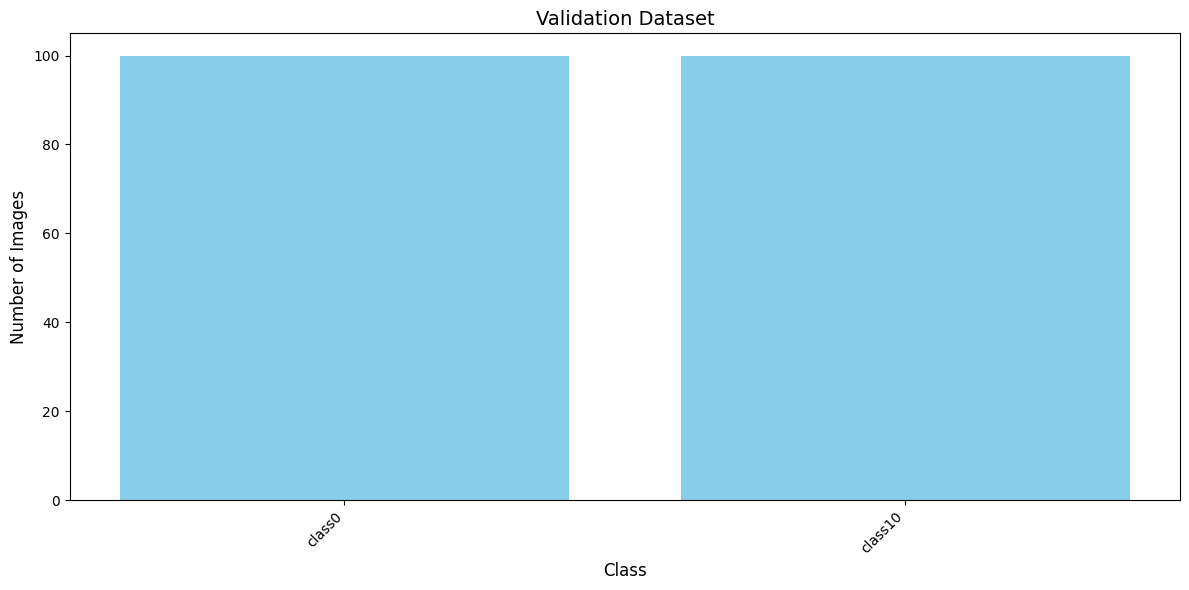

In [18]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dstest/val"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Validation Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
## Combine zoom out and in before augmwnting

In [20]:
import os
import shutil

def copy_files(src_dir, dest_dir):
    """
    Recursively copy files from the source directory to the destination directory,
    maintaining the directory structure.
    
    Args:
    - src_dir: The source directory to copy from
    - dest_dir: The destination directory to copy to
    """
    # Walk through the source directory
    for root, dirs, files in os.walk(src_dir):
        # Calculate relative path from the source directory
        rel_path = os.path.relpath(root, src_dir)
        # Define the corresponding destination path
        dest_path = os.path.join(dest_dir, rel_path)
        
        # Create the directories in the destination if they don't exist
        os.makedirs(dest_path, exist_ok=True)
        
        # Copy each file to the destination
        for file in files:
            src_file = os.path.join(root, file)
            dest_file = os.path.join(dest_path, file)
            shutil.copy2(src_file, dest_file)  # copy2 to preserve file metadata
            print(f"Copied: {src_file} -> {dest_file}")

def main():
    # Define source and destination directories
    src_train_dir = "dsout/train"
    src_val_dir = "dsout/val"
    dest_train_dir = "dstest/train"
    dest_val_dir = "dstest/val"
    
    # Copy from dsout/train to dstest/train
    print("Copying files from dsout/train to dstest/train...")
    copy_files(src_train_dir, dest_train_dir)
    
    # Copy from dsout/val to dstest/val
    print("Copying files from dsout/val to dstest/val...")
    copy_files(src_val_dir, dest_val_dir)
    
    print("\nFiles copied successfully!")

if __name__ == "__main__":
    main()


Copying files from dsout/train to dstest/train...
Copied: dsout/train\class0\images\env_Balete-A-4-_jpg.rf.524333d6467f2a405d4fdb55f03ac50f(z0.84).jpg -> dstest/train\class0\images\env_Balete-A-4-_jpg.rf.524333d6467f2a405d4fdb55f03ac50f(z0.84).jpg
Copied: dsout/train\class0\images\env_Balete-B-8-_jpg.rf.c4cd48d9bff69066b349fc04d3721a01(z0.72).jpg -> dstest/train\class0\images\env_Balete-B-8-_jpg.rf.c4cd48d9bff69066b349fc04d3721a01(z0.72).jpg
Copied: dsout/train\class0\images\env_Balete-BB-5-_jpg.rf.f34c88c262845abf7713666d3436ee77(z0.88).jpg -> dstest/train\class0\images\env_Balete-BB-5-_jpg.rf.f34c88c262845abf7713666d3436ee77(z0.88).jpg
Copied: dsout/train\class0\images\env_Balete-DD-1-_jpg.rf.5fa2d6e642b3e37bbe7d6ced1da0e072(z0.72).jpg -> dstest/train\class0\images\env_Balete-DD-1-_jpg.rf.5fa2d6e642b3e37bbe7d6ced1da0e072(z0.72).jpg
Copied: dsout/train\class0\images\env_Balete-FF-8-_jpg.rf.db52b74d2cff3a877a85a52c1fd6e576(z0.76).jpg -> dstest/train\class0\images\env_Balete-FF-8-_jpg.r

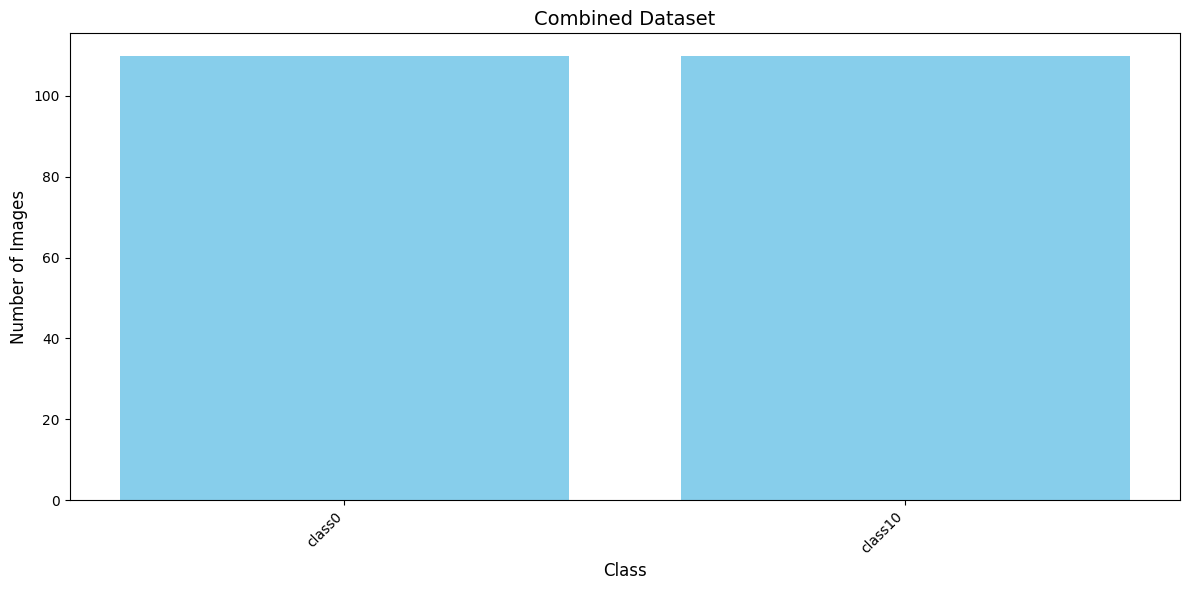

In [22]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dstest/val"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Combined Validation Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


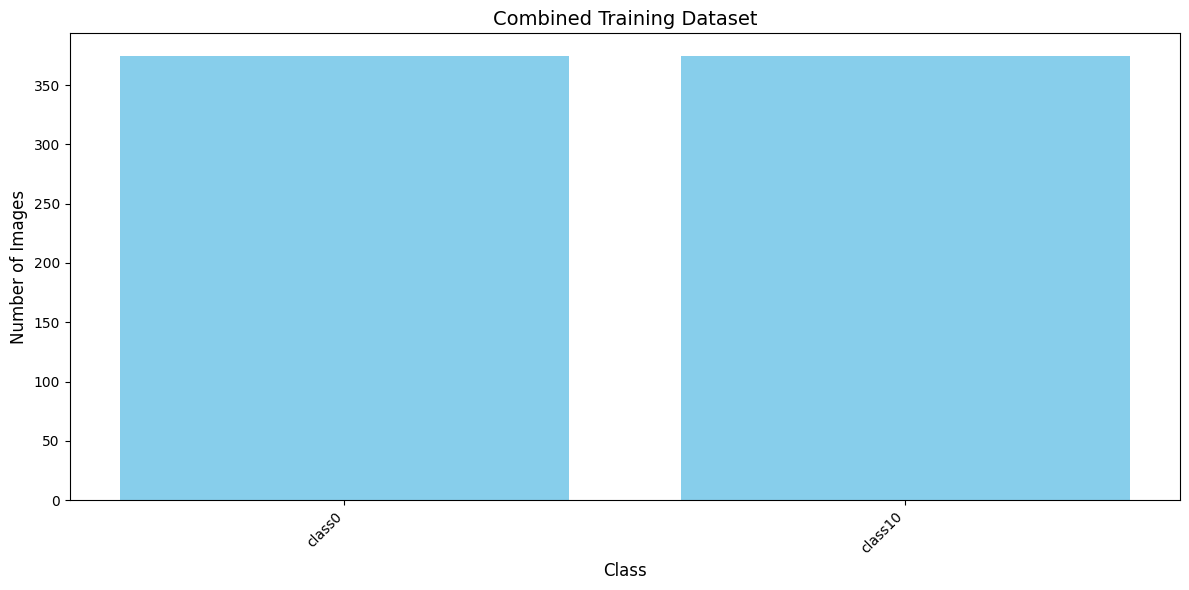

In [23]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dstest/train"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Combined Training Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


## Generate Rotations for Train and Val

In [25]:
import os
import cv2
import numpy as np
import shutil

def rotate_box(box, angle, image_width, image_height):
    """Rotate a YOLO bounding box."""
    # Convert YOLO format to absolute coordinates
    x_center, y_center = box[1] * image_width, box[2] * image_height
    width, height = box[3] * image_width, box[4] * image_height
    
    # Calculate corners
    x1 = x_center - width / 2
    y1 = y_center - height / 2
    x2 = x_center + width / 2
    y2 = y_center + height / 2
    
    # Create rotation matrix
    center = (image_width / 2, image_height / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Rotate corners
    points = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=np.float32)
    rotated_points = np.array([rotation_matrix.dot([p[0], p[1], 1]) for p in points])
    
    # Get new bounding box
    x_min = np.min(rotated_points[:, 0])
    y_min = np.min(rotated_points[:, 1])
    x_max = np.max(rotated_points[:, 0])
    y_max = np.max(rotated_points[:, 1])
    
    # Convert back to YOLO format
    new_x_center = (x_min + x_max) / 2 / image_width
    new_y_center = (y_min + y_max) / 2 / image_height
    new_width = (x_max - x_min) / image_width
    new_height = (y_max - y_min) / image_height
    
    # Clip values to ensure they stay within [0, 1]
    new_x_center = np.clip(new_x_center, 0, 1)
    new_y_center = np.clip(new_y_center, 0, 1)
    new_width = np.clip(new_width, 0, 1)
    new_height = np.clip(new_height, 0, 1)
    
    return [box[0], new_x_center, new_y_center, new_width, new_height]

def augment_class(original_class_path, target_count, angles=[90, 180, 270]):
    """Augment images and labels for a specific class until reaching target count."""
    images_path = os.path.join(original_class_path, "images")
    labels_path = os.path.join(original_class_path, "labels")
    
    # Copy original files first
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(image_files)
    if current_count >= target_count:
        return
    
    augmentation_needed = target_count - current_count
    aug_counter = 0
    angle_idx = 0
    
    while aug_counter < augmentation_needed:
        for img_file in image_files:
            if aug_counter >= augmentation_needed:
                break
                
            label_file = img_file.rsplit('.', 1)[0] + '.txt'
            img_path = os.path.join(images_path, img_file)
            label_path = os.path.join(labels_path, label_file)
            
            if not os.path.exists(label_path):
                continue
                
            img = cv2.imread(img_path)
            height, width = img.shape[:2]
            
            angle = angles[angle_idx % len(angles)]
            rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0)
            rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height))
            
            with open(label_path, 'r') as f:
                labels = [line.strip().split() for line in f.readlines()]
            
            rotated_labels = []
            for label in labels:
                label = [float(x) if i > 0 else int(x) for i, x in enumerate(label)]
                rotated_label = rotate_box(label, angle, width, height)
                rotated_labels.append(rotated_label)
            
            aug_suffix = f'_aug_{angle}_{aug_counter}'
            new_img_file = f"{img_file.rsplit('.', 1)[0]}{aug_suffix}.{img_file.rsplit('.', 1)[1]}"
            new_label_file = f"{label_file.rsplit('.', 1)[0]}{aug_suffix}.txt"
            
            cv2.imwrite(os.path.join(images_path, new_img_file), rotated_img)
            
            with open(os.path.join(labels_path, new_label_file), 'w') as f:
                for label in rotated_labels:
                    f.write(f"{int(label[0])} {' '.join(str(x) for x in label[1:])}\n")
            
            aug_counter += 1
            angle_idx += 1

def balance_dataset(train_dir, target_count=None):
    """Balance the dataset by augmenting classes with fewer images."""
    # Count images per class
    class_counts = {}
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name, "images")
        if os.path.isdir(class_path):
            class_counts[class_name] = len([f for f in os.listdir(class_path) 
                                          if os.path.isfile(os.path.join(class_path, f))])
    
    # If target_count not specified, use the maximum class count
    if target_count is None:
        target_count = max(class_counts.values())
    
    print(f"Target count per class: {target_count}")
    
    # Process each class
    for class_name, count in class_counts.items():
        print(f"\nProcessing class '{class_name}' ({count} images)")
        original_class_path = os.path.join(train_dir, class_name)
        augment_class(original_class_path, target_count)
        
        # Verify new count
        new_count = len([f for f in os.listdir(os.path.join(original_class_path, "images")) 
                        if os.path.isfile(os.path.join(original_class_path, "images", f))])
        print(f"Augmented '{class_name}' to {new_count} images")
    
    print(f"\nDataset augmentation complete.")

# Example usage
if __name__ == "__main__":
    train_dir = "dstest/train"
    balance_dataset(train_dir, target_count=400)  # 349 is the size of the largest class


Target count per class: 400

Processing class 'class0' (375 images)
Augmented 'class0' to 400 images

Processing class 'class10' (375 images)
Augmented 'class10' to 400 images

Dataset augmentation complete.


In [26]:
import os
import cv2
import numpy as np
import shutil

def rotate_box(box, angle, image_width, image_height):
    """Rotate a YOLO bounding box."""
    # Convert YOLO format to absolute coordinates
    x_center, y_center = box[1] * image_width, box[2] * image_height
    width, height = box[3] * image_width, box[4] * image_height
    
    # Calculate corners
    x1 = x_center - width / 2
    y1 = y_center - height / 2
    x2 = x_center + width / 2
    y2 = y_center + height / 2
    
    # Create rotation matrix
    center = (image_width / 2, image_height / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Rotate corners
    points = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=np.float32)
    rotated_points = np.array([rotation_matrix.dot([p[0], p[1], 1]) for p in points])
    
    # Get new bounding box
    x_min = np.min(rotated_points[:, 0])
    y_min = np.min(rotated_points[:, 1])
    x_max = np.max(rotated_points[:, 0])
    y_max = np.max(rotated_points[:, 1])
    
    # Convert back to YOLO format
    new_x_center = (x_min + x_max) / 2 / image_width
    new_y_center = (y_min + y_max) / 2 / image_height
    new_width = (x_max - x_min) / image_width
    new_height = (y_max - y_min) / image_height
    
    # Clip values to ensure they stay within [0, 1]
    new_x_center = np.clip(new_x_center, 0, 1)
    new_y_center = np.clip(new_y_center, 0, 1)
    new_width = np.clip(new_width, 0, 1)
    new_height = np.clip(new_height, 0, 1)
    
    return [box[0], new_x_center, new_y_center, new_width, new_height]

def augment_class(original_class_path, target_count, angles=[90, 180, 270]):
    """Augment images and labels for a specific class until reaching target count."""
    images_path = os.path.join(original_class_path, "images")
    labels_path = os.path.join(original_class_path, "labels")
    
    # Copy original files first
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(image_files)
    if current_count >= target_count:
        return
    
    augmentation_needed = target_count - current_count
    aug_counter = 0
    angle_idx = 0
    
    while aug_counter < augmentation_needed:
        for img_file in image_files:
            if aug_counter >= augmentation_needed:
                break
                
            label_file = img_file.rsplit('.', 1)[0] + '.txt'
            img_path = os.path.join(images_path, img_file)
            label_path = os.path.join(labels_path, label_file)
            
            if not os.path.exists(label_path):
                continue
                
            img = cv2.imread(img_path)
            height, width = img.shape[:2]
            
            angle = angles[angle_idx % len(angles)]
            rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0)
            rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height))
            
            with open(label_path, 'r') as f:
                labels = [line.strip().split() for line in f.readlines()]
            
            rotated_labels = []
            for label in labels:
                label = [float(x) if i > 0 else int(x) for i, x in enumerate(label)]
                rotated_label = rotate_box(label, angle, width, height)
                rotated_labels.append(rotated_label)
            
            aug_suffix = f'_aug_{angle}_{aug_counter}'
            new_img_file = f"{img_file.rsplit('.', 1)[0]}{aug_suffix}.{img_file.rsplit('.', 1)[1]}"
            new_label_file = f"{label_file.rsplit('.', 1)[0]}{aug_suffix}.txt"
            
            cv2.imwrite(os.path.join(images_path, new_img_file), rotated_img)
            
            with open(os.path.join(labels_path, new_label_file), 'w') as f:
                for label in rotated_labels:
                    f.write(f"{int(label[0])} {' '.join(str(x) for x in label[1:])}\n")
            
            aug_counter += 1
            angle_idx += 1

def balance_dataset(train_dir, target_count=None):
    """Balance the dataset by augmenting classes with fewer images."""
    # Count images per class
    class_counts = {}
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name, "images")
        if os.path.isdir(class_path):
            class_counts[class_name] = len([f for f in os.listdir(class_path) 
                                          if os.path.isfile(os.path.join(class_path, f))])
    
    # If target_count not specified, use the maximum class count
    if target_count is None:
        target_count = max(class_counts.values())
    
    print(f"Target count per class: {target_count}")
    
    # Process each class
    for class_name, count in class_counts.items():
        print(f"\nProcessing class '{class_name}' ({count} images)")
        original_class_path = os.path.join(train_dir, class_name)
        augment_class(original_class_path, target_count)
        
        # Verify new count
        new_count = len([f for f in os.listdir(os.path.join(original_class_path, "images")) 
                        if os.path.isfile(os.path.join(original_class_path, "images", f))])
        print(f"Augmented '{class_name}' to {new_count} images")
    
    print(f"\nDataset augmentation complete.")

# Example usage
if __name__ == "__main__":
    train_dir = "dstest/val"
    balance_dataset(train_dir, target_count=200)  # 349 is the size of the largest class


Target count per class: 200

Processing class 'class0' (110 images)
Augmented 'class0' to 200 images

Processing class 'class10' (110 images)
Augmented 'class10' to 200 images

Dataset augmentation complete.


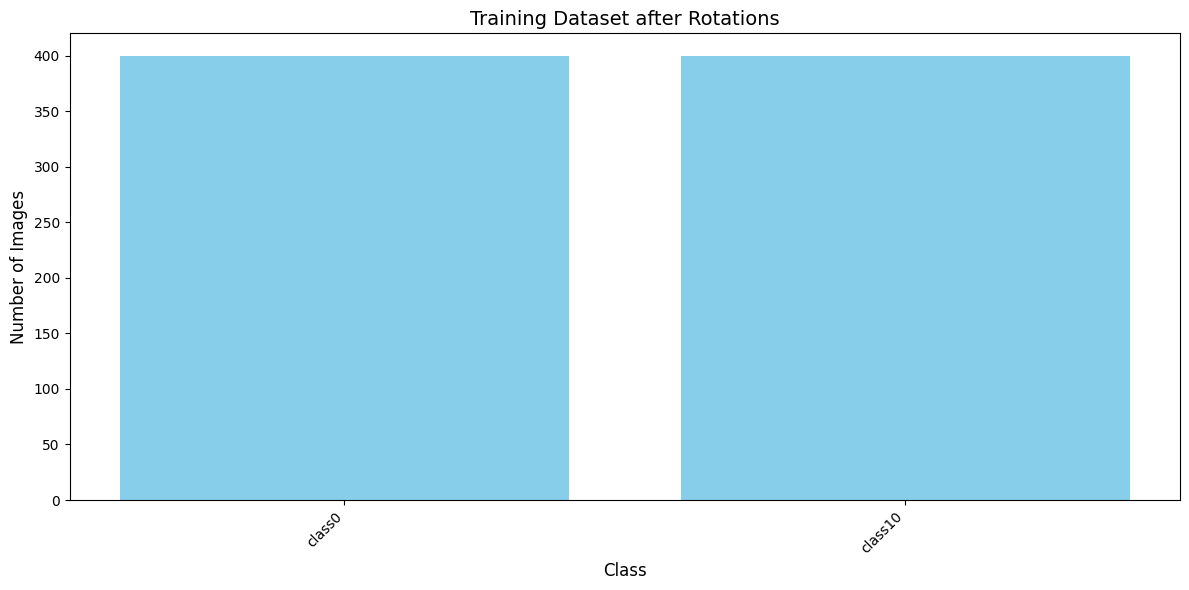

In [27]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dstest/train"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Training Dataset after Rotations", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


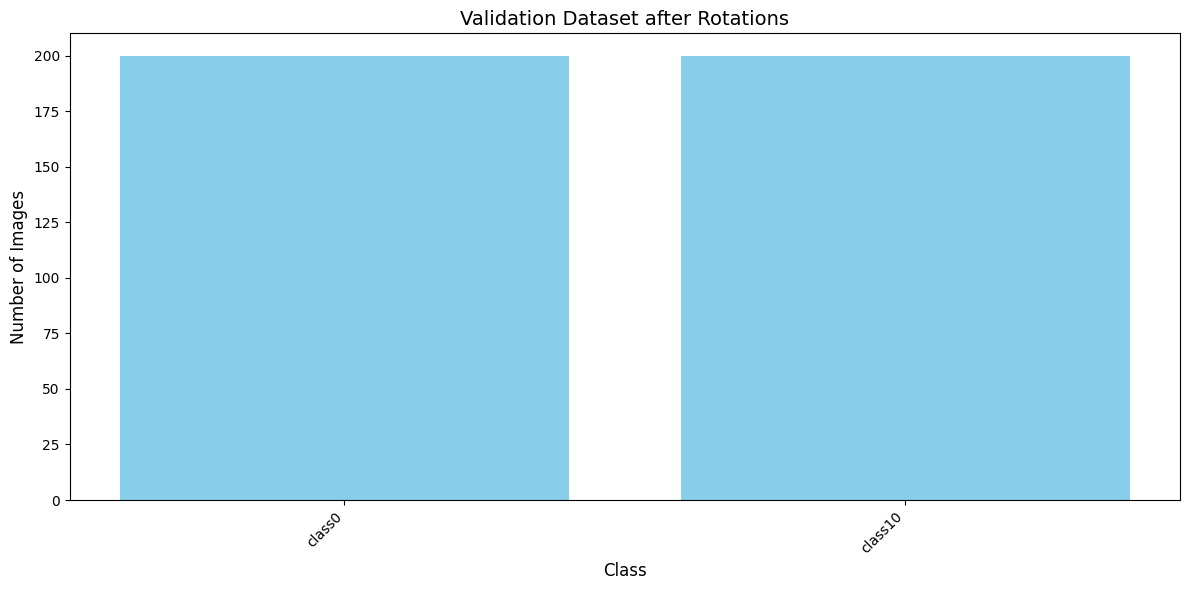

In [28]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dstest/val"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Validation Dataset after Rotations", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


## Plot Random Samples from Train

Plotting random samples from the dataset...


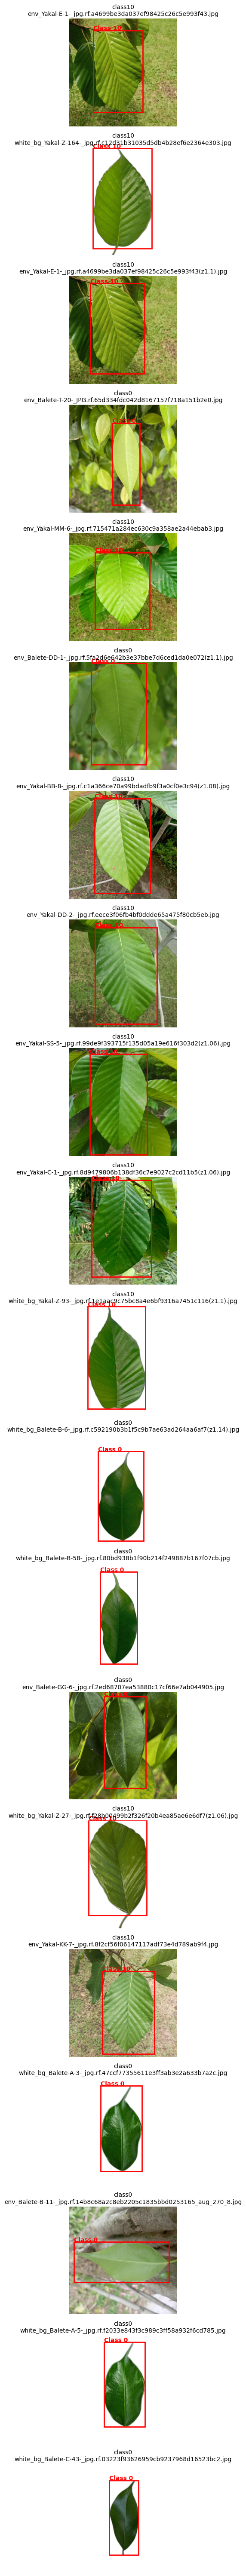

Done!


In [29]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_image_with_boxes(image_path, label_path, ax, title):
    """Plot an image with its bounding boxes and title"""
    # Load image
    image = Image.open(image_path)
    img_width, img_height = image.size

    # Plot image
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(title, fontsize=10, wrap=True)

    # Read and plot bounding boxes
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])

                # Convert YOLO format to corner coordinates
                x_min = (x_center - width / 2) * img_width
                y_min = (y_center - height / 2) * img_height
                box_width = width * img_width
                box_height = height * img_height

                # Draw bounding box
                rect = patches.Rectangle(
                    (x_min, y_min), box_width, box_height,
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                ax.add_patch(rect)
                ax.text(x_min, y_min - 5, f"Class {class_id}", 
                        color='red', fontsize=10, weight='bold')

def plot_random_dataset_samples(base_path, num_samples=20, figsize=(3, 3)):
    """Plot random samples from the dataset in a single column"""
    # Get all class directories
    class_dirs = [d for d in os.listdir(base_path) if d.startswith('class')]
    
    # Collect all image paths and their corresponding label paths
    all_images = []
    for class_dir in class_dirs:
        images_dir = os.path.join(base_path, class_dir, 'images')
        labels_dir = os.path.join(base_path, class_dir, 'labels')
        
        for image_file in os.listdir(images_dir):
            if image_file.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(images_dir, image_file)
                label_path = os.path.join(labels_dir, 
                                        os.path.splitext(image_file)[0] + '.txt')
                all_images.append((image_path, label_path, class_dir))
    
    # Randomly select images
    selected_images = random.sample(all_images, min(num_samples, len(all_images)))
    
    # Create subplot grid for a single column
    num_rows = len(selected_images)
    fig, axs = plt.subplots(num_rows, 1, figsize=(figsize[0], num_rows * figsize[1]))
    
    if num_rows == 1:  # Handle case where only one sample is selected
        axs = [axs]
    
    # Plot each selected image
    for i, (image_path, label_path, class_dir) in enumerate(selected_images):
        # Create title from filename and class
        filename = os.path.basename(image_path)
        title = f"{class_dir}\n{filename}"
        
        # Plot image with boxes
        plot_image_with_boxes(image_path, label_path, axs[i], title)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Path to your dataset directory containing class0, class1, etc.
    dataset_path = "dstest/train"  # Adjust this to your dataset path
    
    print("Plotting random samples from the dataset...")
    plot_random_dataset_samples(dataset_path, num_samples=20)
    print("Done!")


## Plot Random Samples from Val

Plotting random samples from the dataset...


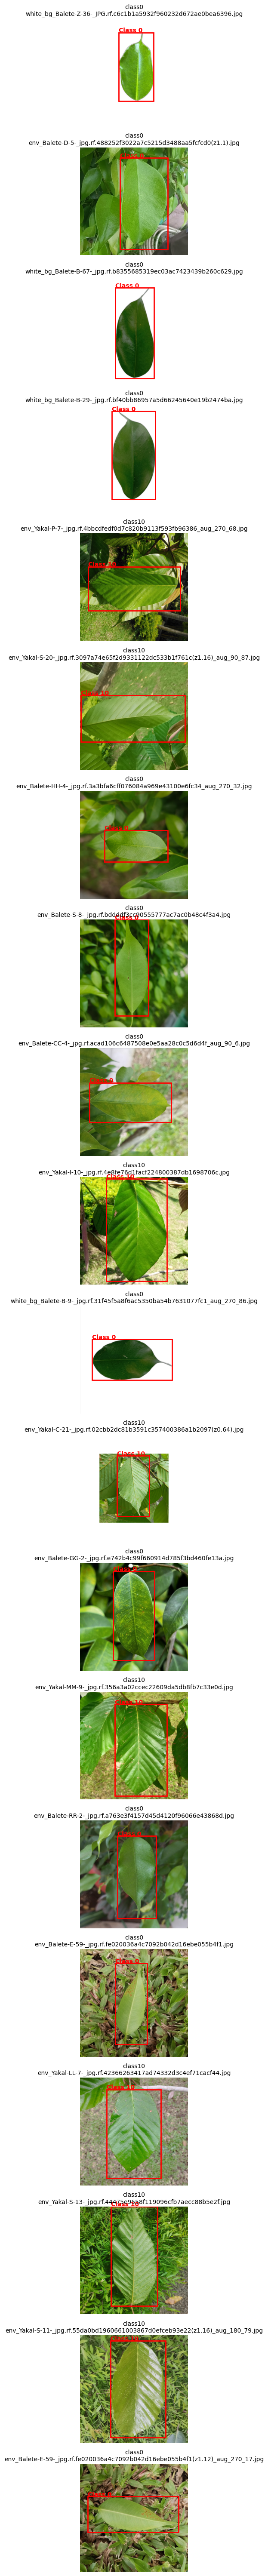

Done!


In [30]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_image_with_boxes(image_path, label_path, ax, title):
    """Plot an image with its bounding boxes and title"""
    # Load image
    image = Image.open(image_path)
    img_width, img_height = image.size

    # Plot image
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(title, fontsize=10, wrap=True)

    # Read and plot bounding boxes
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])

                # Convert YOLO format to corner coordinates
                x_min = (x_center - width / 2) * img_width
                y_min = (y_center - height / 2) * img_height
                box_width = width * img_width
                box_height = height * img_height

                # Draw bounding box
                rect = patches.Rectangle(
                    (x_min, y_min), box_width, box_height,
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                ax.add_patch(rect)
                ax.text(x_min, y_min - 5, f"Class {class_id}", 
                        color='red', fontsize=10, weight='bold')

def plot_random_dataset_samples(base_path, num_samples=20, figsize=(3, 3)):
    """Plot random samples from the dataset in a single column"""
    # Get all class directories
    class_dirs = [d for d in os.listdir(base_path) if d.startswith('class')]
    
    # Collect all image paths and their corresponding label paths
    all_images = []
    for class_dir in class_dirs:
        images_dir = os.path.join(base_path, class_dir, 'images')
        labels_dir = os.path.join(base_path, class_dir, 'labels')
        
        for image_file in os.listdir(images_dir):
            if image_file.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(images_dir, image_file)
                label_path = os.path.join(labels_dir, 
                                        os.path.splitext(image_file)[0] + '.txt')
                all_images.append((image_path, label_path, class_dir))
    
    # Randomly select images
    selected_images = random.sample(all_images, min(num_samples, len(all_images)))
    
    # Create subplot grid for a single column
    num_rows = len(selected_images)
    fig, axs = plt.subplots(num_rows, 1, figsize=(figsize[0], num_rows * figsize[1]))
    
    if num_rows == 1:  # Handle case where only one sample is selected
        axs = [axs]
    
    # Plot each selected image
    for i, (image_path, label_path, class_dir) in enumerate(selected_images):
        # Create title from filename and class
        filename = os.path.basename(image_path)
        title = f"{class_dir}\n{filename}"
        
        # Plot image with boxes
        plot_image_with_boxes(image_path, label_path, axs[i], title)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Path to your dataset directory containing class0, class1, etc.
    dataset_path = "dstest/val"  # Adjust this to your dataset path
    
    print("Plotting random samples from the dataset...")
    plot_random_dataset_samples(dataset_path, num_samples=20)
    print("Done!")


## Plot Specific Images

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to plot image with bounding boxes and original image side by side
def plot_original_and_zoomed(original_image_path, zoomed_image_path, original_label_path, zoomed_label_path):
    # Load images
    original_image = Image.open(original_image_path)
    zoomed_image = Image.open(zoomed_image_path)
    img_width, img_height = zoomed_image.size

    # Create a figure with two subplots for the original and zoomed images
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))

    # Plot the original image
    axs[0].imshow(original_image)
    axs[0].axis('off')
    axs[0].set_title("Original Image")

    # Plot the zoomed image with bounding boxes
    axs[1].imshow(zoomed_image)
    axs[1].axis('off')
    axs[1].set_title("Generated Zoomed Image")

    # Read and plot bounding boxes for the original image
    with open(original_label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convert YOLO format to corner coordinates
            x_min = (x_center - width / 2) * img_width
            y_min = (y_center - height / 2) * img_height
            x_max = (x_center + width / 2) * img_width
            y_max = (y_center + height / 2) * img_height

            # Draw bounding box on the original image
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            axs[0].add_patch(rect)
            axs[0].text(x_min, y_min - 5, f"Class {class_id}", color='red', fontsize=10, weight='bold')

    # Read and plot bounding boxes for the zoomed image
    with open(zoomed_label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convert YOLO format to corner coordinates
            x_min = (x_center - width / 2) * img_width
            y_min = (y_center - height / 2) * img_height
            x_max = (x_center + width / 2) * img_width
            y_max = (y_center + height / 2) * img_height

            # Draw bounding box on the zoomed image
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            axs[1].add_patch(rect)
            axs[1].text(x_min, y_min - 5, f"Class {class_id}", color='red', fontsize=10, weight='bold')

    plt.tight_layout()
    plt.show()

# File paths
original_image_path = "dsds/val/class20/images/env_Sintores-SS-1-_jpg.rf.d998a5d8243d075eeea3ae06f0252958.jpg"
zoomed_image_path = "dsds/val/class20/images/env_Sintores-SS-1-_jpg.rf.d998a5d8243d075eeea3ae06f0252958(z1.16).jpg"
original_label_path = "dsds/val/class20/labels/env_Sintores-SS-1-_jpg.rf.d998a5d8243d075eeea3ae06f0252958.txt"
zoomed_label_path = "dsds/val/class20/labels/env_Sintores-SS-1-_jpg.rf.d998a5d8243d075eeea3ae06f0252958(z1.16).txt"

# Plot the original and zoomed images with bounding boxes
plot_original_and_zoomed(original_image_path, zoomed_image_path, original_label_path, zoomed_label_path)


## Restructure Data for Training

In [31]:
import os
import shutil

# Source and destination paths
source_dir = "dstest"
dest_dir = "Augmented_test_Dataset"

def copy_files(source, destination):
    if not os.path.exists(destination):
        os.makedirs(destination)

    for root, _, files in os.walk(source):
        for file in files:
            file_path = os.path.join(root, file)
            shutil.copy(file_path, destination)

# Paths for train and val datasets
train_images_dest = os.path.join(dest_dir, "train", "images")
train_labels_dest = os.path.join(dest_dir, "train", "labels")
val_images_dest = os.path.join(dest_dir, "val", "images")
val_labels_dest = os.path.join(dest_dir, "val", "labels")

# Function to copy images and labels
print("Copying training images and labels...")
for class_idx in range(36):
    class_path = f"class{class_idx}"
    copy_files(os.path.join(source_dir, "train", class_path, "images"), train_images_dest)
    copy_files(os.path.join(source_dir, "train", class_path, "labels"), train_labels_dest)

print("Copying validation images and labels...")
for class_idx in range(36):
    class_path = f"class{class_idx}"
    copy_files(os.path.join(source_dir, "val", class_path, "images"), val_images_dest)
    copy_files(os.path.join(source_dir, "val", class_path, "labels"), val_labels_dest)

print("Dataset reorganization complete.")


Copying training images and labels...
Copying validation images and labels...
Dataset reorganization complete.


## Train using yolov8

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  # Load a pretrained model (recommended for training)

# Define the path to the dataset YAML file
train_results = model.train(data="C://Users//ben//Documents//augment_labels/dataout.yaml", epochs=50, imgsz=640, device=0)



New https://pypi.org/project/ultralytics/8.3.50 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.86  Python-3.12.4 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C://Users//ben//Documents//augment_labels/dataout.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, ret

train: Scanning C:\Users\ben\Documents\augment_labels\Augmented_test_Dataset\train\labels... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:01<00:00, 619.64it/s]


train: New cache created: C:\Users\ben\Documents\augment_labels\Augmented_test_Dataset\train\labels.cache


val: Scanning C:\Users\ben\Documents\augment_labels\Augmented_test_Dataset\val\labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:01<00:00, 263.99it/s]


val: New cache created: C:\Users\ben\Documents\augment_labels\Augmented_test_Dataset\val\labels.cache
Plotting labels to runs\detect\train7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00025, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train7
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.41G     0.6438      4.007       1.25         34        640: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [00:04<00:02,  2.21it/s]